In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms #convertir a tensor
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
import torch
import numpy as np

# comprobar si CUDA está disponible
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA no está disponible. Entrenamiento en CPU ...')
else:
    print('¡CUDA está disponible! Entrenamiento en GPU ...')

CUDA no está disponible. Entrenamiento en CPU ...


In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# número de subprocesos a utilizar para la carga de datos
num_workers = 0
# cuantas muestras por lote cargar
batch_size = 20
# porcentaje del conjunto de entrenamiento para usar como validación
valid_size = 0.2

# convertir datos a un normalizada torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# elegir los conjuntos de datos de entrenamiento y prueba
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtener índices de entrenamiento que se utilizarán para la validación
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# definir muestreadores para obtener lotes de entrenamiento y validación
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# preparar cargadores de datos (combinar conjunto de datos y muestra)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# especificar las clases de imagen
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


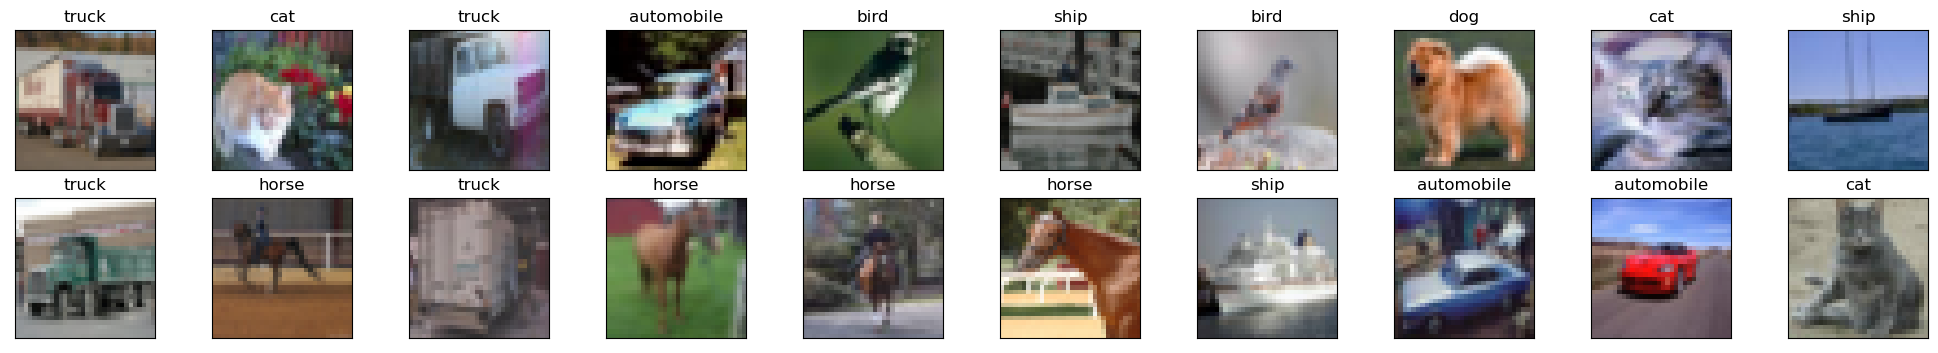

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# función auxiliar para desnormalizar y mostrar una imagen
def imshow(img):
    img = img / 2 + 0.5  # desnormalizar
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image (de tensor a imagen)

# obtener un lote de imágenes de entrenamiento
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convertir imágenes a numpy para mostrar
# dibuja las imágenes en el lote, junto con las etiquetas correspondientes
fig = plt.figure(figsize=(25, 4))
# muestra 20 imagenes
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

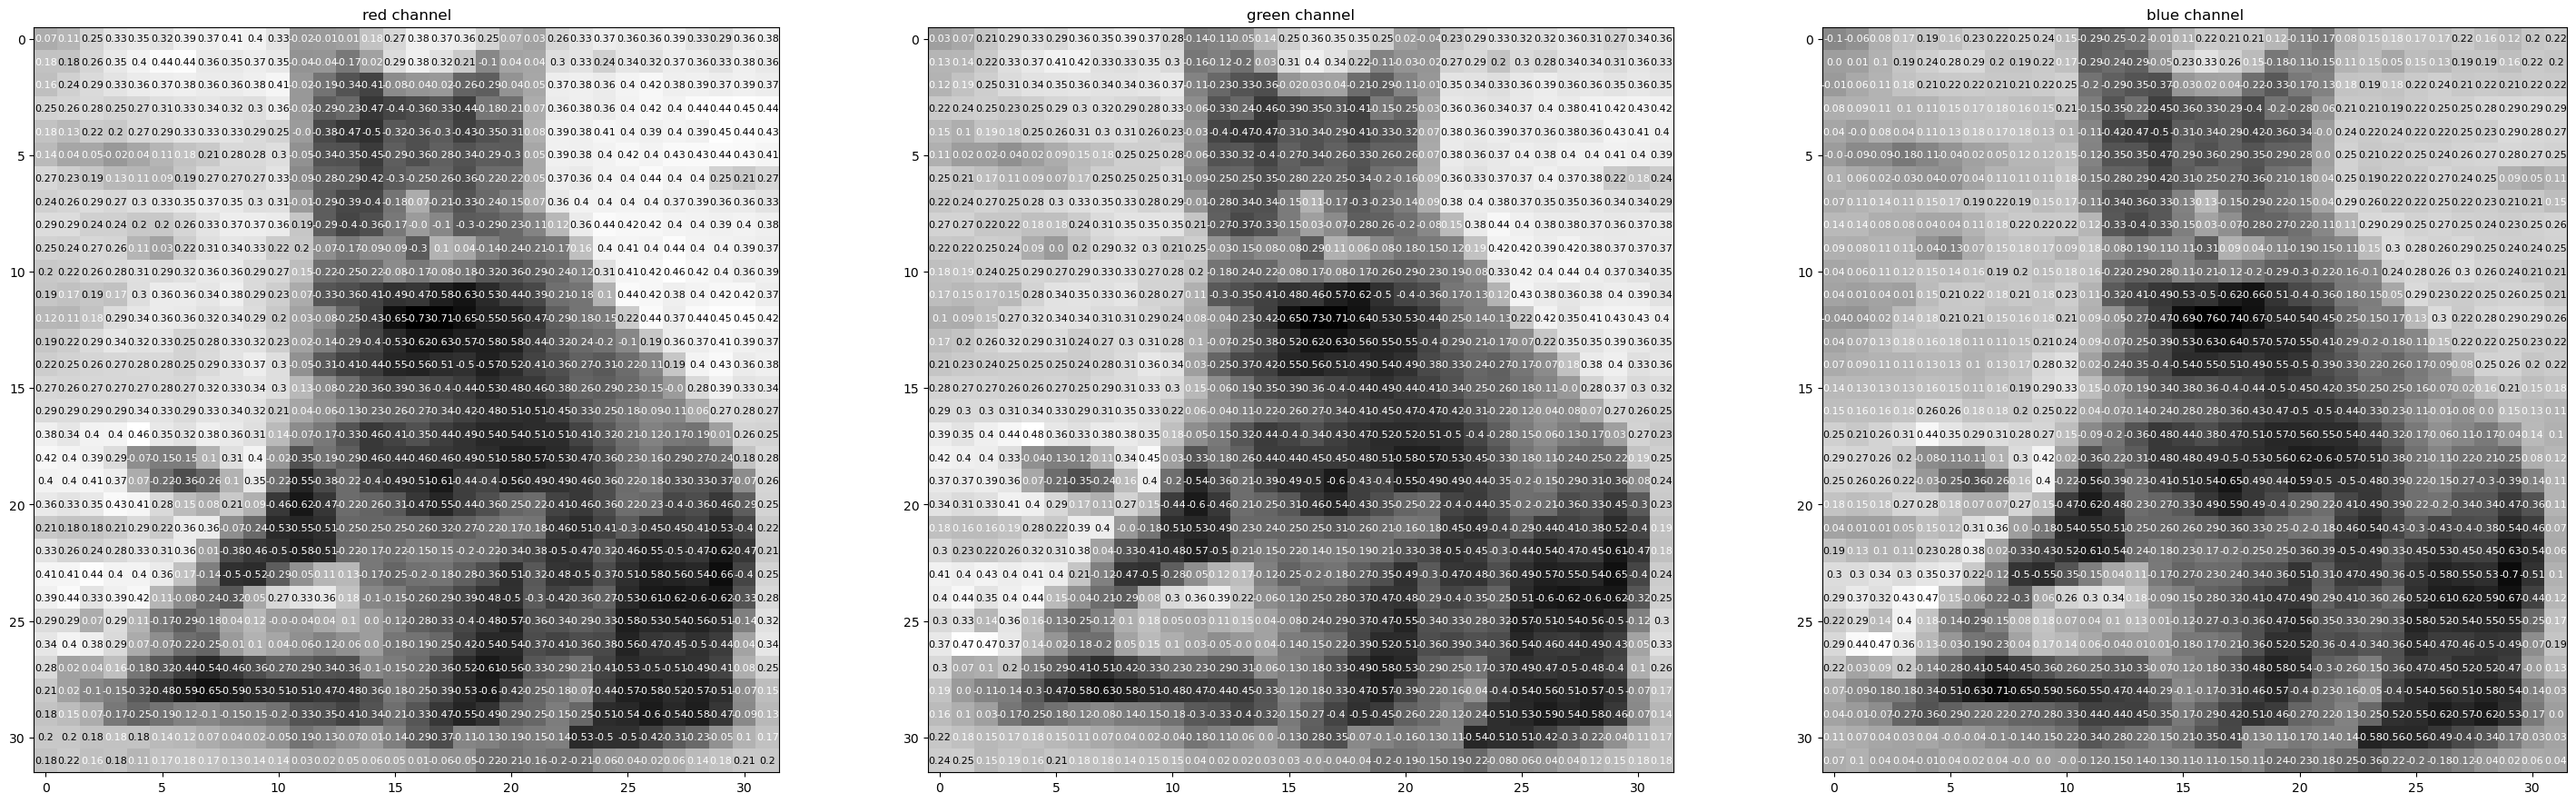

In [5]:
rgb_img = np.squeeze(images[19])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')


In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
    
# crear una CNN completa
model = Net()
print(model)
# mover tensores a GPU si CUDA está disponible
if train_on_gpu:
  model.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [8]:
import torch.optim as optim
# Especifica funcion de perdidas
criterion = nn.CrossEntropyLoss()
# Especifica optimizador
optimizer = optim.SGD(model.parameters(), lr=.01)

In [9]:
# número de epochs para entrenar el modelo
n_epochs = 30
# Lista para almacenar pérdidas, para visualizar
train_losslist = []
valid_loss_min = np.Inf # realizar un seguimiento del cambio en la pérdida de validación

for epoch in range(1, 30):

    # Realizar un seguimiento del cambio en la pérdida de validación
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # Entrena el modelo #
    ###################
    model.train()
    for data, target in train_loader:
        # mover tensores a GPU si CUDA está disponible
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # borrar los gradientes de todas las variables optimizadas
        optimizer.zero_grad()
        # forward pass: calcule las salidas predichas pasando las entradas al modelo
        output = model(data)
        # calcular la pérdida del lote(batch)
        loss = criterion(output, target)
        # backward pass: calcular el gradiente de la pérdida con respecto a los parámetros del modelo
        loss.backward()
        # realizar un único paso de optimización (actualización de parámetros)
        optimizer.step()
        # actualizar pérdida de entrenamiento
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validar el modelo #
    ######################
    model.eval()
    for data, target in valid_loader:
        # mover tensores a GPU si CUDA está disponible
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: calcular las salidas predichas pasando entradas al modelo
        output = model(data)
        # calcular la pérdida del lote(batch)
        loss = criterion(output, target)
        # actualizar la pérdida de validación promedio 
        valid_loss += loss.item()*data.size(0)
    
    # calcular pérdidas promedio
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losslist.append(train_loss)
        
    # imprimir estadísticas de entrenamiento/validación
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # guarde el modelo si la pérdida de validación ha disminuido
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 1.729643 	Validation Loss: 0.390436
Validation loss decreased (inf --> 0.390436).  Saving model ...
Epoch: 2 	Training Loss: 1.393475 	Validation Loss: 0.316456
Validation loss decreased (0.390436 --> 0.316456).  Saving model ...
Epoch: 3 	Training Loss: 1.207909 	Validation Loss: 0.311773
Validation loss decreased (0.316456 --> 0.311773).  Saving model ...
Epoch: 4 	Training Loss: 1.121076 	Validation Loss: 0.271657
Validation loss decreased (0.311773 --> 0.271657).  Saving model ...
Epoch: 5 	Training Loss: 1.051432 	Validation Loss: 0.260594
Validation loss decreased (0.271657 --> 0.260594).  Saving model ...
Epoch: 6 	Training Loss: 0.994700 	Validation Loss: 0.247493
Validation loss decreased (0.260594 --> 0.247493).  Saving model ...
Epoch: 7 	Training Loss: 0.949540 	Validation Loss: 0.249272
Epoch: 8 	Training Loss: 0.906930 	Validation Loss: 0.247517
Epoch: 9 	Training Loss: 0.871864 	Validation Loss: 0.233650
Validation loss decreased (0.247493 --> 0.

In [10]:
print(type(train_losslist))
print(n_epochs)
n_epochs=[*range(1,30)]

<class 'list'>
30


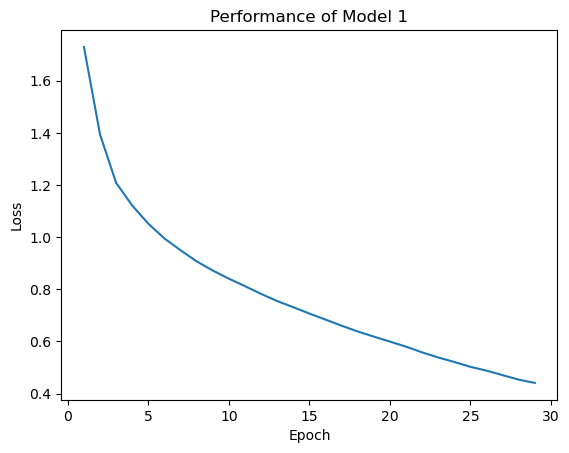

In [11]:
plt.plot(n_epochs, train_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model 1")
plt.show()

In [12]:
# track test loss (Seguimiento de pérdida de prueba)
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterar sobre datos de prueba
for data, target in test_loader:
    # mover tensores a GPU si CUDA está disponible
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: calcular las salidas predichas pasando entradas al modelo
    output = model(data)
    # calcular la pérdida del lote(batch)
    loss = criterion(output, target)
    # actualización de pérdida de prueba 
    test_loss += loss.item()*data.size(0)
    # convertir las probabilidades de salida a la clase predicha
    _, pred = torch.max(output, 1)    
    # comparar predicciones con la etiqueta(label) verdadera
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calcular la precisión de la prueba para cada clase de objeto
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# pérdida de prueba promedio
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.301628

Test Accuracy of airplane: 66% (666/1000)
Test Accuracy of automobile: 81% (811/1000)
Test Accuracy of  bird: 42% (429/1000)
Test Accuracy of   cat: 42% (423/1000)
Test Accuracy of  deer: 64% (641/1000)
Test Accuracy of   dog: 46% (465/1000)
Test Accuracy of  frog: 78% (784/1000)
Test Accuracy of horse: 64% (640/1000)
Test Accuracy of  ship: 75% (750/1000)
Test Accuracy of truck: 66% (663/1000)

Test Accuracy (Overall): 62% (6272/10000)


In [13]:
class CNN(nn.Module):
   

    def __init__(self):
        
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x



#_______________________________________________________________________
#VER COMO CONSTRUÍ LA RED:

# Crear una cnn completa
model = CNN()
print(model)
# mover tensores a GPU si CUDA está disponible
if train_on_gpu:
  model.cuda()

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [14]:
import torch.optim as optim
# Especificar funcion de perdidas
criterion = nn.CrossEntropyLoss()
# especificar optimizador
optimizer = optim.SGD(model.parameters(), lr=.001)

In [16]:
# número de epochs para entrenar el modelo
n_epochs = 30
#Lista para almacenar pérdida para visualizar
train_losslist = []
valid_loss_min = np.Inf # realizar un seguimiento del cambio en la pérdida de validación

for epoch in range(1, 30):

    # hacer un seguimiento de la pérdida de entrenamiento y validación
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # Entrena al modelo #
    ###################
    model.train()
    for data, target in train_loader:
        # mover tensores a GPU si CUDA está disponible
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # limpia(clear) los gradientes de todas las variables optimizadas
        optimizer.zero_grad()
        # forward pass: calcular las salidas predichas pasando entradas al modelo
        output = model(data)
        # calcular la pérdida del lote(batch)
        loss = criterion(output, target)
        # backward pass: calcular el gradiente de la pérdida con respecto a los parámetros del modelo
        loss.backward()
        # realizar un único paso de optimización (actualización de parámetros)
        optimizer.step()
        # actualizar pérdida de entrenamiento
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # Valida el modelo #
    ######################
    model.eval()
    for data, target in valid_loader:
        # mover tensores a GPU si CUDA está disponible
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: calcular las salidas predichas pasando entradas al modelo
        output = model(data)
        # calcular la pérdida del lote(batch)
        loss = criterion(output, target)
        # actualizar la pérdida de validación promedio 
        valid_loss += loss.item()*data.size(0)
    
    # calcular pérdidas promedio
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losslist.append(train_loss)
        
    # imprimir estadísticas de entrenamiento/validación
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # guarde el modelo si la pérdida de validación ha disminuido
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.356213 	Validation Loss: 0.304724
Validation loss decreased (inf --> 0.304724).  Saving model ...
Epoch: 2 	Training Loss: 1.181386 	Validation Loss: 0.275732
Validation loss decreased (0.304724 --> 0.275732).  Saving model ...
Epoch: 3 	Training Loss: 1.064822 	Validation Loss: 0.243390
Validation loss decreased (0.275732 --> 0.243390).  Saving model ...
Epoch: 4 	Training Loss: 0.967043 	Validation Loss: 0.221623
Validation loss decreased (0.243390 --> 0.221623).  Saving model ...
Epoch: 5 	Training Loss: 0.875910 	Validation Loss: 0.216364
Validation loss decreased (0.221623 --> 0.216364).  Saving model ...
Epoch: 6 	Training Loss: 0.802120 	Validation Loss: 0.197063
Validation loss decreased (0.216364 --> 0.197063).  Saving model ...
Epoch: 7 	Training Loss: 0.741624 	Validation Loss: 0.183591
Validation loss decreased (0.197063 --> 0.183591).  Saving model ...
Epoch: 8 	Training Loss: 0.686513 	Validation Loss: 0.170409
Validation loss decreased (0.18359

In [17]:
print(type(train_losslist))
print(n_epochs)
n_epochs=[*range(1,30)]

<class 'list'>
30


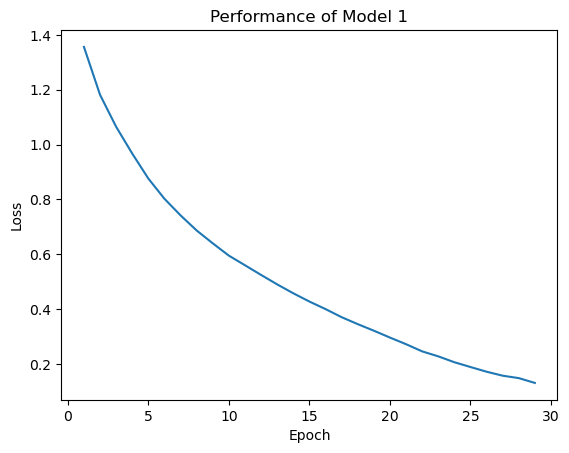

In [18]:
plt.plot(n_epochs, train_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model 1")
plt.show()

In [19]:
# track test loss (Seguimiento de pérdida de prueba)
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterar sobre datos de prueba
for data, target in test_loader:
    # mover tensores a GPU si CUDA está disponible
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: calcular las salidas predichas pasando entradas al modelo
    output = model(data)
    # calcular la pérdida del lote(batch)
    loss = criterion(output, target)
    # actualización de pérdida de prueba 
    test_loss += loss.item()*data.size(0)
    # convertir las probabilidades de salida a la clase predicha
    _, pred = torch.max(output, 1)    
    # comparar predicciones con la etiqueta(label) verdadera
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calcular la precisión de la prueba para cada clase de objeto
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# pérdida de prueba promedio
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.872186

Test Accuracy of airplane: 79% (793/1000)
Test Accuracy of automobile: 88% (884/1000)
Test Accuracy of  bird: 66% (665/1000)
Test Accuracy of   cat: 49% (493/1000)
Test Accuracy of  deer: 62% (623/1000)
Test Accuracy of   dog: 82% (822/1000)
Test Accuracy of  frog: 88% (889/1000)
Test Accuracy of horse: 77% (774/1000)
Test Accuracy of  ship: 82% (820/1000)
Test Accuracy of truck: 87% (875/1000)

Test Accuracy (Overall): 76% (7638/10000)
